## This module is to evaluate the performance of the GNN model,under heads attention 8, edge features 4

In [1]:
import sys
from pathlib import Path
import numpy as np

sys.argv = [
    'track_zephir_anchors_final.py',
    '2',
    '1', ## match_method
    'dataset/ZM9624_masked_anchor',
    'dataset/ZM9624_masked_anchor',
    '.7',
    '0.78',
    'ZM9624_masked_h8/model/loss_train.pt',
    'eval',
    "None",
    "None",
    "None",
    "None"
]


In [2]:

import time

def compute_link_matrix(model, t1, t2, graph_path, threshold, use_nms,  device):
    data1, data2 = get_pair_data(graph_path,int(t1),int(t2),device)
    model.eval()
    with torch.no_grad():
        all_match_scores_m, score_matrix = model.forward_link_back(data1, data2, threshold, use_nms)
    return score_matrix

def compute_chain_link_matrix(model, t_chain_list, graph_path,threshold, use_nms, device):
    score_matrix_chain = None
    for i, t1 in  enumerate(t_chain_list[:-1]) : 
        t2 = t_chain_list[i+1]
        score_matrix_12 = compute_link_matrix(model, t1, t2, graph_path,threshold, use_nms,  device)
        if score_matrix_chain is None:
            score_matrix_chain = score_matrix_12.float()
        else:
            score_matrix_chain = score_matrix_chain.float() @ score_matrix_12.float()
    return score_matrix_chain

def propagate_chian_t_ref(model,sim_tree, t_ref, t_target, graph_path,threshold, use_nms, device):

    score_matrix_chain = 0

    t_chain_list0 = [t_ref, t_target]
    t_chain_list1 = [t_ref, np.argmin(sim_tree[t_ref]),t_target]
    t_chain_list2 = [t_ref, np.argmin(sim_tree[t_target]),t_target]
    t_chain_list_all = [ t_chain_list0, t_chain_list1, t_chain_list2]
    for t_chain_list in t_chain_list_all:            
        score_matrix_chain += compute_chain_link_matrix(model, t_chain_list, graph_path,threshold, use_nms, device)
            
    return score_matrix_chain


def match_chain_of_reference(model, t_track, graph_path, t_initial_list, sim_tree, threshold, use_nms, device):

    t_track = list(set(t_track) - set(t_initial_list))

    df_all =  pd.DataFrame()
    for t_target in tqdm(t_track):
        
        df_target =  pd.DataFrame()
        for t_ref in t_initial_list:

            data_ref, data_target= get_pair_data(graph_path,int(t_ref),int(t_target),device)
            score_matrix = propagate_chian_t_ref(model,sim_tree, t_ref, t_target, graph_path,threshold, use_nms, device)
            
            selected_index = np.array([2,0,1])
            ind = torch.where(score_matrix==1)

            child_coords = data_target.x[ind[1]][:,selected_index].detach().cpu().numpy() /norm_scale
            parent_coords = data_ref.x[ind[0]][:,selected_index].detach().cpu().numpy() /norm_scale
            
            
            df_t2 = {
                    't_idx': t_target,
                    'z': child_coords[:,0],
                    'y': child_coords[:,1],
                    'x': child_coords[:,2],
                    'ind':ind[1].detach().cpu().numpy() - 1,
        
                    'parent_id': t_ref,
                    'parent_coords_z': parent_coords[:,0],
                    'parent_coords_y': parent_coords[:,1],
                    'parent_coords_x': parent_coords[:,2],
                    'worldline_id': data_ref.y[ind[0]].detach().cpu().numpy() - 1,
                    'provenance': b'GNN'
                             }

            
            df = pd.DataFrame.from_dict(df_t2)
            df_target = pd.concat([df_target,df])
    
        df_target = df_target.drop_duplicates(subset=['ind', 'worldline_id'], keep='first')
        df_target = df_target[~df_target['worldline_id'].duplicated(keep=False) & ~df_target['ind'].duplicated(keep=False)]
    
        df_all = pd.concat([df_all,df_target])
    
    return df_all

In [3]:


import os
conda_env = os.environ.get('CONDA_DEFAULT_ENV')
print(f"Current conda environment: {conda_env}")

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import os
import shutil
import json
import csv
import pandas as pd
from scipy.io import loadmat
import cv2
import torch
import sys
torch.cuda.is_available()
from zephir.main import run_zephir
from zephir.utils.io import load_checkpoint, update_checkpoint
from zephir.methods.build_pdists import get_all_pdists
from zephir.__version__ import __version__
print("zephir version: ",__version__)
from datetime import datetime
from IPython.display import clear_output
from MatchPartial.parameters import *
from MatchPartial.load_func import *
from MatchPartial.utilize_func import *
from MatchPartial.model_sim_EGAT_v2_test import *
from MatchPartial.eval_prediction_func import *
def similarity_t_pairs(dataset,shape_t, channel,t_track,t_initial_list):
    d_full = get_all_pdists(dataset, shape_t, channel, pbar=True)
    t_track_actual = np.array(list(set(t_track) -set(t_initial_list)))
    a = np.array(t_initial_list)[np.argmin(d_full[:,np.array(t_initial_list)], axis = 1)]
    result = np.stack((a[np.array(t_track_actual)], np.array(t_track_actual)), axis=1)
    return result



dataset = Path(dataset_path)
print("starting tracking", flush=True)
print(dataset_path, flush=True)
# with open(str(dataset / 'args.json')) as json_file:
#     args = json.load(json_file)
print("the args:", args, flush=True) 




##########################################################################################################################
##                           Make initial annotations here                                                              ##
###weights_path#######################################################################################################################
    
t0 = time.time()

annotation_orig = get_annotation_file_df(folder_path, "annotations_orig.h5") 
annotation = pd.DataFrame()
for t_initial in t_initial_list:
    df = annotation_orig[annotation_orig['t_idx']==t_initial] 
    annotation = pd.concat([annotation,df], ignore_index=True)
key_list = annotation.keys().tolist()
key_list.remove('id')
print("save initial annotations in the current folder",dataset_path/file_name)
##########################################################################################################################



##########################################################################################################################
##      If the partial annotations are saved as annotations.h5 already                                            ##
##########################################################################################################################
    
# annotation = get_annotation_df(dataset) 
##########################################################################################################################

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NodeLevelGNN(nearby_search_num, norm_scale, with_AM, device).to(device)

model.load_state_dict(torch.load(weights_path)['model'])
print(weights_path)

Current conda environment: base
zephir version:  1.0.5
match_method [1] <class 'list'>
weights_path: /work/venkatachalamlab/Hang/00Neuron_tracking_version2/01version/tracking/ZM9624_masked_h8/model/loss_train.pt
loading environment variables
match_method: [1]
folder_path: /work/venkatachalamlab/Hang/00Neuron_tracking_version2/01version/dataset/ZM9624_masked_anchor
threshold 0.7
save_folder /work/venkatachalamlab/Hang/00Neuron_tracking_version2/01version/dataset/ZM9624_masked_anchor
loading args from /work/venkatachalamlab/Hang/00Neuron_tracking_version2/01version/dataset/ZM9624_masked_anchor
starting tracking
/work/venkatachalamlab/Hang/00Neuron_tracking_version2/01version/dataset/ZM9624_masked_anchor
the args: {'--help': False, '--version': False, '--dataset': '.', '--dimmer_ratio': '0.1', '--n_epoch_d': '0', '--motion_predict': 'True', '--grid_shape': '49', '--fovea_sigma': '10.0', '--lr_coef': '2.0', '--t_track': None, '--allow_rotation': 'True', '--z_compensator': '4.0', '--n_epoch

In [4]:
def compute_acc_dist_num(dataset_orig, df_tracked, t_track, norm_scale):
    df_orig = get_annotation_file_df(dataset_orig,'annotations_orig.h5')
    df_tracked = df_tracked[df_tracked['t_idx'].isin(t_track)]
    df_tracked = df_tracked.sort_values(['t_idx', 'worldline_id']).reset_index(drop=True)
    df_result = df_orig[
    df_orig[['t_idx', 'worldline_id']].apply(tuple, axis=1).isin(
        df_tracked[['t_idx', 'worldline_id']].apply(tuple, axis=1)
        )
        ]
    df_matched_compare = df_result.sort_values(['t_idx', 'worldline_id']).reset_index(drop=True)    
    diff = (df_tracked[['z','y','x']].values - df_matched_compare[['z','y','x']].values) * norm_scale
    diff_scale = np.sqrt(np.sum(diff* diff, axis = 1))
    acc = round(np.sum(diff_scale < 4) / len(diff_scale), 3)
    num_matched = len(diff_scale)
    # print("accuracy", round(np.sum(diff_scale < 4) / len(diff_scale), 3), round(np.mean(diff_scale), 3), len(diff))
    return acc, num_matched

In [5]:
######################## Method 1: using all t_refs  to match all cross-link
if match_method == [1] or match_method  == [1,4]:
    
    t_pairs = similarity_t_pairs(dataset,shape_t, channel,t_track,t_initial_list)
    print("obtain the most similary reference frame")
    
    # df_all = match_pair_df_reference_filter(t_pairs, model, graph_path, method, nearby_search_num, norm_scale, with_AM, device, threshold, use_nms)

    match_acc_list = []
    # for threshold in tqdm(np.arange(0.8)):
    for threshold in [0.7]:
        # df_all = match_pair_df_reference_filter(t_pairs, model, graph_path, method, nearby_search_num, norm_scale, with_AM, device, threshold, use_nms)
        df_all = match_pair_df_reference(t_pairs, model, graph_path, method, nearby_search_num, norm_scale, with_AM, device, threshold, use_nms)
        df_matched = df_all[['parent_id', 'provenance', 't_idx', 'worldline_id', 'x', 'y','z']]
        df_matched = df_matched.sort_values(['t_idx', 'worldline_id']).reset_index(drop=True)
        # acc, num_matched = compare_df_match_orig(folder_path/'annotations_orig.h5',df_matched,norm_scale)
        acc, num_matched = compute_acc_dist_num(folder_path, df_matched, t_track, norm_scale)
        match_acc_list.append( [threshold, acc, num_matched] )
    match_acc_list = np.array(match_acc_list)
    df = pd.DataFrame(match_acc_list, columns=['threshold','acc','num_matched'])
    # df.to_hdf('match_acc_list.h5', key='data', mode='w')
    df['matched_ave'] = df['num_matched']/(len(t_pairs)-3)
    print(df)



The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
obtain the most similary reference frame


100%|██████████| 1057/1057 [02:55<00:00,  6.01it/s]


   threshold    acc  num_matched  matched_ave
0        0.7  0.968      63001.0    59.773245


In [34]:
    
def compute_acc_dist(dataset_orig, df_tracked, t_track, norm_scale):
    df_orig = get_annotation_file_df(dataset_orig,'annotations_orig.h5')
    df_tracked = df_tracked[df_tracked['t_idx'].isin(t_track)]
    df_tracked = df_tracked.sort_values(['t_idx', 'worldline_id']).reset_index(drop=True)
    df_result = df_orig[
    df_orig[['t_idx', 'worldline_id']].apply(tuple, axis=1).isin(
        df_tracked[['t_idx', 'worldline_id']].apply(tuple, axis=1)
        )
        ]
    df_matched_compare = df_result.sort_values(['t_idx', 'worldline_id']).reset_index(drop=True)    
    diff = (df_tracked[['z','y','x']].values - df_matched_compare[['z','y','x']].values) * norm_scale
    diff_scale = np.sqrt(np.sum(diff* diff, axis = 1))
    print("accuracy", round(np.sum(diff_scale < 4) / len(diff_scale), 3), round(np.mean(diff_scale), 3), len(diff))
    return acc


In [208]:
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator
t_idx = 0
norm_scale = np.array([23,512,512]) -1
acc_list = []
df_tracked_all = pd.DataFrame() 
t_track = list(set(list(np.arange(1060))) -set([444, 498, 463]))[0:365]
t_track = [0]
for t_idx in tqdm(t_track):
    df_t_idx = df_all[df_all['t_idx'] == t_idx].sort_values(by='worldline_id')
    
    coords_anchor_child = df_t_idx[['z','y','x']].values
    coords_anchor_parent = df_t_idx[['parent_coords_z','parent_coords_y','parent_coords_x']].values

    
    
    df_orig = get_annotation_file_df(dataset,'annotations_orig.h5')
    t_parent = df_t_idx['parent_id'][0]
    coords_parent = df_orig[df_orig['t_idx'] == t_parent][['z','y','x','worldline_id']].values

    
    
    
    # ##### Method 1: linear interpolation
    coords_child = griddata(
        points=coords_anchor_parent ,     # known parent anchor points
        values=coords_anchor_child,      # known child values at those anchors
        xi=coords_parent[:,0:3],                # full parent list to interpolate onto
        method='linear'                  # or 'nearest' / 'cubic'
    )


    

    #### Method 2: RBFInterpolator interpolation
    if len(coords_anchor_parent) > 4:
        # interp = RBFInterpolator(coords_anchor_parent[0:10], coords_anchor_child[0:10] )
        # coords_child = interp(coords_parent[:,0:3]) 


        
        df_tracked = pd.DataFrame()
        df_tracked[['z', 'y', 'x']] = coords_child
        df_tracked['t_idx'] = t_idx
        df_tracked['worldline_id'] = coords_parent[:,3]

        
        df_tracked_all = pd.concat([df_tracked_all, df_tracked], ignore_index=True)



acc = compute_acc_dist(dataset, df_tracked_all, list(t_track), norm_scale)
# acc_list.append([t_idx,acc])

100%|██████████| 1/1 [00:00<00:00, 19.55it/s]


accuracy 0.478 nan 178


In [8]:
from zephir_dev.models.zephir import ZephIR
from zephir_dev.utils.utils import *

def corr_similarity(prediction, target):
    """Image registration loss, L_R.

    Normalized correlation loss between two lists of volumes (T, N, C, Z, Y, X).
    Loss is calculated over (C, Z, Y, X) axes and averaged over (N) axis. (T) axis
    is not reduced.

    :param prediction: child descriptors
    :param target: target descriptors
    :return: loss
    """

    vx = prediction - torch.mean(prediction, dim=[2, 3, 4, 5], keepdim=True)
    vy = target - torch.mean(target, dim=[2, 3, 4, 5], keepdim=True)
    # child descriptors can sometimes be empty and cause DivByZero error
    if torch.any(torch.std(prediction, dim=[2, 3, 4, 5]) == 0):
        sx = torch.std(prediction, dim=[2, 3, 4, 5])
        for t in range(sx.shape[0]):
            sx[t][sx[t] == 0] = 1
        sxy = torch.mul(torch.std(target, dim=[2, 3, 4, 5]),
                        torch.std(target, dim=[2, 3, 4, 5]))
    else:
        sxy = torch.mul(torch.std(prediction, dim=[2, 3, 4, 5]),
                        torch.std(target, dim=[2, 3, 4, 5]))
    cc = torch.div(torch.mean(torch.mul(vx, vy), dim=[2, 3, 4, 5]), sxy + 1e-5)
    return cc



def build_zephir(args, ZephIR, img_shape, shape_n, n_frame):
    allow_rotation = False
    dimmer_ratio = float(args['--dimmer_ratio'])
    grid_shape = (5,  2 * (int(args['--grid_shape']) // 2) + 1, 2 * (int(args['--grid_shape']) // 2) + 1)
    fovea_sigma = (1, float(args['--fovea_sigma']), float(args['--fovea_sigma']))
    n_chunks = int(args['--n_chunks'])
    n_frame = int(args['--n_frame'])
    grid_spacing = tuple(np.array(grid_shape) / np.array(img_shape))
    
    channel = int(args['--channel'])
    gamma = float(args['--gamma'])
    model_kwargs = {
        'allow_rotation': allow_rotation,
        'dimmer_ratio': dimmer_ratio,
        'fovea_sigma': fovea_sigma,
        'grid_shape': grid_shape,
        'grid_spacing': grid_spacing,
        'n_chunks': n_chunks,
        'n_frame': n_frame,
        'shape_n': shape_n,
        'ftr_ratio': 0.6,
        'ret_stride': 2,
    }
    
    zephir = ZephIR(**model_kwargs)
    return zephir



def extract_img_descriptor(dataset, zephir, xyz_norm, t_idx, gamma, channel, dev):

    data = get_data(dataset, t_idx, g=gamma, c=channel)
    vol = to_tensor(data, n_dim=5, grad=False, dev=dev)
    input_tensor = torch.stack([vol], dim=0)
    zephir.theta.zero_()
    zephir.rho = torch.nn.Parameter(torch.zeros_like(zephir.rho), requires_grad=True)
    
    xyz_anchor = to_tensor(xyz_norm,dev=dev) * 2 - 1
    rho_new = zephir.rho.clone().to(dev)
    rho_new[:1] = rho_new[:1] + xyz_anchor.detach().expand(1, -1, -1)
    zephir.rho = torch.nn.Parameter(rho_new, requires_grad=True)
    
    zephir.to(dev)
    pred = zephir(input_tensor)
    return pred



def compute_corr_sim(annotation, df_target_t_idx, args, ZephIR, img_shape, dev):
    channel = int(args['--channel'])
    gamma = float(args['--gamma'])
    t_target= np.unique(df_target_t_idx['t_idx'].values)[0]
    xyz_target = df_target_t_idx[['x','y','z']].values

    shape_n = len(xyz_target.reshape(-1,3))
    t_target_list = df_target_t_idx['t_idx'].values

    zephir_target = build_zephir(args, ZephIR, img_shape, shape_n, len(np.unique(t_target_list)))
    target = extract_img_descriptor(dataset, zephir_target, xyz_target, t_target, gamma, channel, dev)

    
    t_ref = np.unique(df_target_t_idx['parent_id'].values)[0]

    df_ref_t_idx = annotation[
        annotation[['t_idx', 'worldline_id']].apply(tuple, axis=1).isin(
            df_target_t_idx[['parent_id', 'worldline_id']].apply(tuple, axis=1)
            )
            ]

    
    xyz_ref = df_ref_t_idx[['x','y','z']].values

    shape_n = len(xyz_ref.reshape(-1,3))
    t_ref_list = df_ref_t_idx['t_idx'].values
    
    zephir_ref = build_zephir(args, ZephIR, img_shape, shape_n, len(np.unique(t_ref_list)))
    ref = extract_img_descriptor(dataset, zephir_ref, xyz_ref, t_ref, gamma, channel, dev)

    # print(torch.sum(target-ref))
    return corr_similarity(target, ref).detach().cpu().numpy()

In [9]:
import copy
annotation = copy.deepcopy(df_all)
for t_initial in t_initial_list:
    df = annotation_orig[annotation_orig['t_idx']==t_initial] 
    annotation = pd.concat([annotation,df], ignore_index=True)

annotation = annotation.drop_duplicates(subset=['t_idx', 'worldline_id', 'x', 'y', 'z'])
annotation = annotation.sort_values(['t_idx', 'worldline_id']).reset_index(drop=True)
# save_h5_path = 'post_processing/annotation_linkchain.h5'
# save_pandas_h5(save_h5_path, annotation)

dev = 'cuda'
sim_list = []
annotation['corr_sim'] = np.nan  # or any default value
# img_shape = np.array([23, 512, 512])
img_shape = np.array(norm_scale) + 1
t_idx_list = np.unique(annotation['t_idx'].values)

for t_idx in tqdm(t_track):
# for t_idx in [0]:
    for t_ref in t_initial_list:                                           # [498,444,463]
        df_target_t_idx = annotation[(annotation['t_idx']==t_idx) & (annotation['parent_id']==t_ref)]
        if len(df_target_t_idx) > 0:
            sim = compute_corr_sim(annotation, df_target_t_idx, args, ZephIR, img_shape, dev)
            mask = (annotation['t_idx']==t_idx) & (annotation['parent_id']==t_ref)
            annotation.loc[mask, 'corr_sim'] = sim.flatten()[:mask.sum()]
            # sim_list.append(sim)


sim.flatten()

100%|██████████| 1060/1060 [13:10<00:00,  1.34it/s]


array([0.6793503 , 0.78703237, 0.7676988 , 0.8060872 , 0.45455363,
       0.8020981 , 0.65453804, 0.7907043 , 0.42225185, 0.67045534,
       0.7574864 , 0.6119437 , 0.7633919 , 0.9162386 , 0.8666016 ,
       0.9190609 , 0.8032042 , 0.6337945 , 0.59101146, 0.90002614,
       0.8110859 , 0.71313   , 0.6441439 , 0.8974756 , 0.5682834 ,
       0.79333675, 0.6814025 , 0.8397297 , 0.75079566, 0.80235153,
       0.3850848 , 0.7811747 , 0.7480934 , 0.5891898 , 0.7332137 ,
       0.81037366, 0.7985752 , 0.79336554, 0.8447052 , 0.8975765 ,
       0.86431515, 0.89382696, 0.87393326, 0.84707254, 0.8032801 ,
       0.7980115 , 0.7267284 , 0.8551748 , 0.81289387, 0.7791116 ,
       0.819353  , 0.8220874 , 0.8922168 , 0.89280444, 0.8887016 ,
       0.7954137 , 0.90687984, 0.87035656, 0.9221593 , 0.8873998 ,
       0.8631302 , 0.78818077, 0.70260817, 0.8388484 , 0.82118815,
       0.6992472 , 0.87162745, 0.8559237 ], dtype=float32)

In [10]:
dataset_orig  = Path('dataset/ZM9624/')
df_orig = get_annotation_file_df(dataset_orig,'annotations_orig.h5')
df_result = df_orig[
df_orig[['t_idx', 'worldline_id']].apply(tuple, axis=1).isin(
    annotation[['t_idx', 'worldline_id']].apply(tuple, axis=1)
    )
    ]
df_result = df_result.sort_values(['t_idx', 'worldline_id']).reset_index(drop=True)
annotation = annotation.sort_values(['t_idx', 'worldline_id']).reset_index(drop=True)
diff_coords = (df_result[['z','y','x']].values-annotation[['z','y','x']].values) * (np.array(img_shape)-1)
diff_dist = np.sqrt(np.sum(diff_coords **2, axis =1))
annotation['diff_dist'] = diff_dist



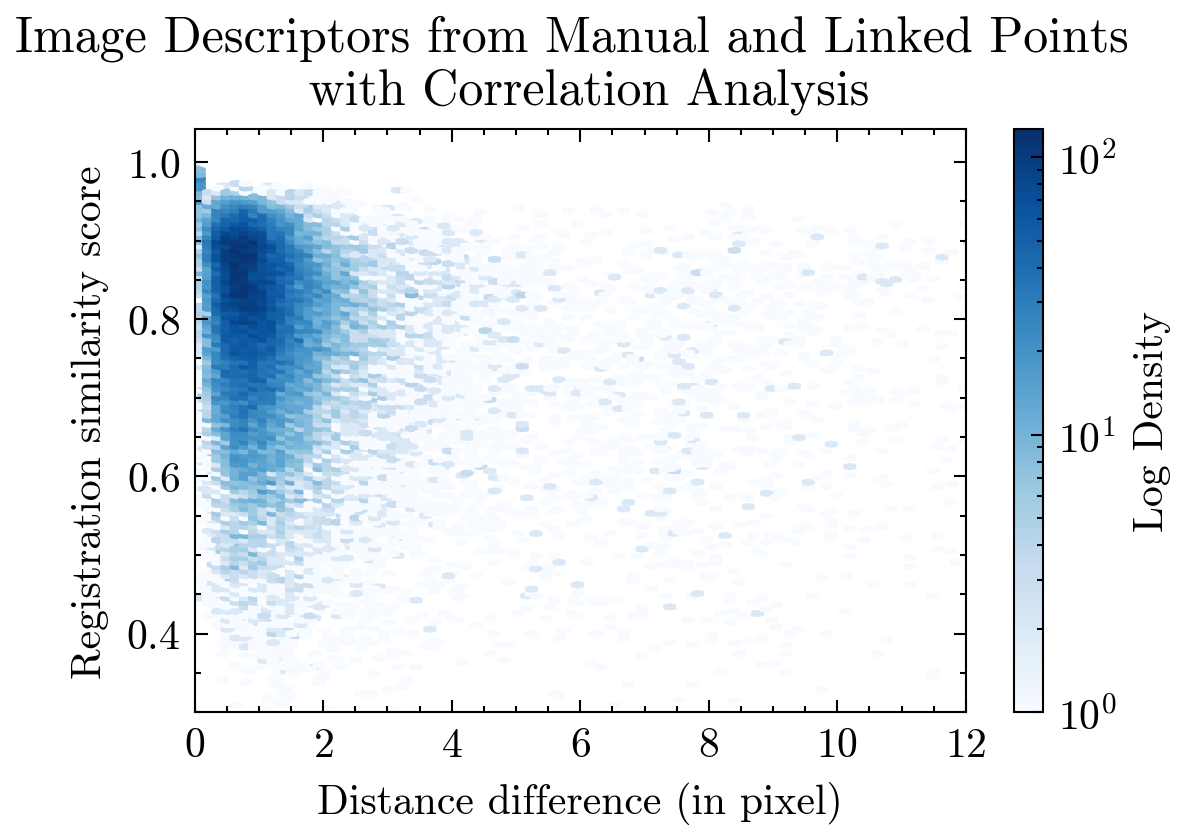

In [11]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter
import scienceplots
x = annotation['diff_dist'].values
y = annotation['corr_sim'].values

x_ref = annotation[annotation['t_idx'].isin(t_initial_list)]['diff_dist'].values
y_ref = annotation[annotation['t_idx'].isin(t_initial_list)]['corr_sim'].values


plt.style.use(['science','no-latex'])
plt.figure(figsize=(4,3),dpi = 300)
plt.hexbin(x, y, gridsize=300, cmap='Blues', bins='log', alpha=1)



plt.xlim(0, 12)
plt.ylim(0.3)
plt.xlabel("Distance difference (in pixel)")
plt.ylabel("Registration similarity score")
plt.title("Image Descriptors from Manual and Linked Points \n with Correlation Analysis")
plt.colorbar(label='Log Density')
plt.tight_layout()
# plt.savefig("./paper_plots/distribution.png",dpi=300, transparent=True)
plt.show()
plt.show()

100%|██████████| 100/100 [00:00<00:00, 2291.86it/s]


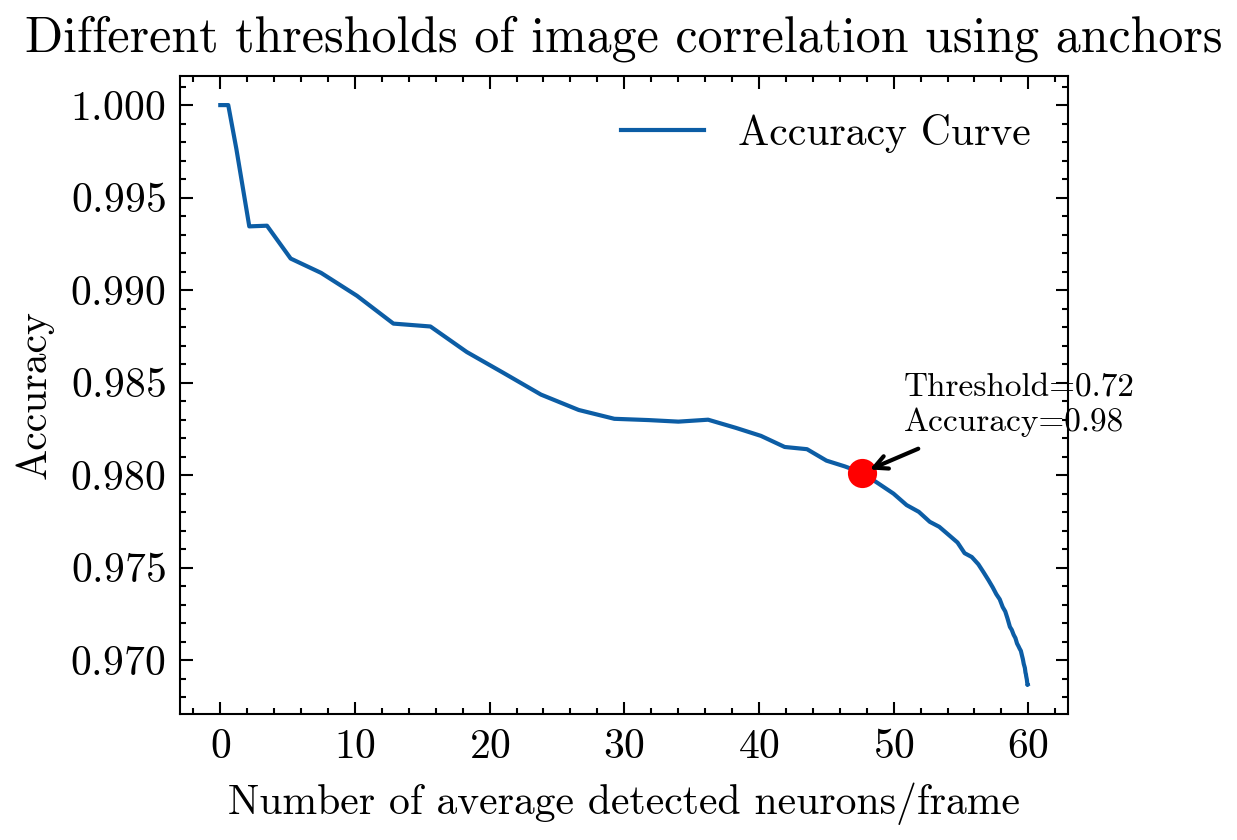

best_threshold 0.43 0.9700481256332321
num 59.59245283018868


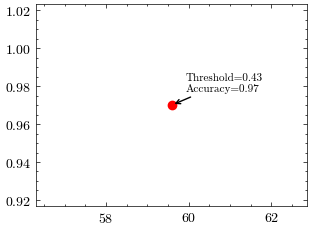

In [12]:
x = annotation['diff_dist'].values
y = annotation['corr_sim'].values
num_list = []
acc_list = []
thr_list = []

t_track = len(np.unique((annotation['t_idx'].values)))
for thr in tqdm(np.arange(0,1,0.01)):
    dis = x[y > thr]
    acc = np.sum(dis < 4) / len(dis)
    num = len(dis) / t_track
    acc_list.append(acc)
    num_list.append(num)
    thr_list.append(thr)

plt.style.use(['science','no-latex'])
plt.figure(figsize=(4,3),dpi = 300)
plt.plot(num_list, acc_list, label='Accuracy Curve')
plt.xlabel("Number of average detected neurons/frame")
plt.ylabel("Accuracy")
plt.title("Different thresholds of image correlation using anchors")




# Find and mark the first point where accuracy > 0.98
ind = np.argwhere(np.array(acc_list) > 0.98)[0][0]
best_threshold = thr_list[ind]
best_num = num_list[ind]
best_acc = acc_list[ind]
plt.plot(best_num, best_acc, 'ro')  # red dot
plt.annotate(f"Threshold={best_threshold:.2f}\nAccuracy={best_acc:.2f}",
             (best_num, best_acc),
             textcoords="offset points", xytext=(10,10), ha='left',
             fontsize=8, arrowprops=dict(arrowstyle='->', lw=1))

plt.legend()
plt.tight_layout()
plt.show()


# Find and mark the first point where accuracy > 0.98
ind = np.argwhere(np.array(acc_list) > 0.97)[0][0]
best_threshold = thr_list[ind]
best_num = num_list[ind]
best_acc = acc_list[ind]
plt.plot(best_num, best_acc, 'ro')  # red dot
plt.annotate(f"Threshold={best_threshold:.2f}\nAccuracy={best_acc:.2f}",
             (best_num, best_acc),
             textcoords="offset points", xytext=(10,10), ha='left',
             fontsize=8, arrowprops=dict(arrowstyle='->', lw=1))



print("best_threshold", best_threshold, best_acc)
print("num", best_num)
